<a href="https://colab.research.google.com/github/NeuroDesk/example-notebooks/blob/main/bids_conversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Google Colab"/>   </a>

# BIDS conversion

Author: Thuy Dao

Citation:
- dcm2niix: https://doi.org/10.1016/j.jneumeth.2016.03.001
- bidscoin: https://doi.org/10.3389/fninf.2021.770608
- heudiconv: https://doi.org/10.5281/zenodo.1012598
- FSL: https://doi.org/10.1016/j.neuroimage.2011.09.015
- OSF: https://doi.org/10.5195/jmla.2017.88
- NiiVue: https://github.com/niivue/niivue

## Setup Neurodesk

In [1]:
%%capture
import os
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  os.environ["LD_PRELOAD"] = "";
  os.environ["APPTAINER_BINDPATH"] = "/content,/tmp,/cvmfs"
  os.environ["MPLCONFIGDIR"] = "/content/matplotlib-mpldir"
  os.environ["LMOD_CMD"] = "/usr/share/lmod/lmod/libexec/lmod"

  !curl -J -O https://raw.githubusercontent.com/NeuroDesk/neurocommand/main/googlecolab_setup.sh
  !chmod +x googlecolab_setup.sh
  !./googlecolab_setup.sh

  os.environ["MODULEPATH"] = ':'.join(map(str, list(map(lambda x: os.path.join(os.path.abspath('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/'), x),os.listdir('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/')))))

In [2]:
# Output CPU information:
!cat /proc/cpuinfo | grep 'vendor' | uniq
!cat /proc/cpuinfo | grep 'model name' | uniq

vendor_id	: AuthenticAMD
model name	: AMD EPYC 7742 64-Core Processor


## BIDS conversion and Open data sharing

1. In this interactive example notebook, we first download DICOM data using `datalad`.

2. Next we will convert DICOMS into the BIDS data structure using:
    - 2.1. `dcm2niix` which convert data to NIfTi and then manually organize the folder.
    - 2.2. `heudiconv` to automate the conversion and organization with a provided heuristic file.
    - 2.3. `bidscoin` to automate the conversion and organization with bideditor interface.

3. We will then run skull stripping using FSL BET.

4. Finally, we will upload output from FSL BET to share in OSF project.

## 1. Data preparation

Download DICOM data from OSF

In [ ]:
%%bash
datalad install https://datasets.datalad.org/repronim/heudiconv-reproin-example
cd heudiconv-reproin-example/REPROIN/dicom && datalad get 001

Cloning: 100%|██████████████████████| 2.00/2.00 [00:01<00:00, 1.22 candidates/s]
Enumerating: 0.00 Objects [00:00, ? Objects/s]
                                              
Counting:   0%|                              | 0.00/12.4k [00:00<?, ? Objects/s]
Counting:   5%|█▏                     | 619/12.4k [00:00<00:02, 4.09k Objects/s]
                                                                                
Compressing:   0%|                           | 0.00/6.00k [00:00<?, ? Objects/s]
                                                                                
Receiving:   0%|                             | 0.00/12.4k [00:00<?, ? Objects/s]
Receiving:   1%|▏                       | 124/12.4k [00:00<00:15, 786 Objects/s]
Receiving:   6%|█▎                    | 743/12.4k [00:00<00:05, 2.05k Objects/s]
Receiving:  18%|███▌                | 2.23k/12.4k [00:00<00:01, 5.79k Objects/s]
Receiving:  25%|█████               | 3.09k/12.4k [00:00<00:01, 5.53k Objects/s]
Receiving:  44%

We will be working from a directory called `REPROIN`. Under the REPROIN directory is the `dicom` subdirectory: Under the subject number `001` the session `Patterson_Coben - 1` is nested. Each dicom sequence folder is nested under the session:

In [ ]:
!tree heudiconv-reproin-example/REPROIN/dicom

## 2. Convert DICOMS to BIDS-formatted NIFTI

### 2.1. Using dcm2niix (manual workflow)

`dcm2niix` converts neuroimaging data from the DICOM format to the NIfTI format and generates a BIDS JSON format sidecar which includes relevant information. However, users need to manually organize these files into a bids-compliant subject directory.

In [6]:
import lmod
await lmod.load('dcm2niix/v1.0.20240202')

In [20]:
!dcm2niix -h

Chris Rorden's dcm2niiX version v1.0.20230411  GCC12.2.0 x86-64 (64-bit Linux)
usage: dcm2niix [options] <in_folder>
 Options :
  -1..-9 : gz compression level (1=fastest..9=smallest, default 6)
  -a : adjacent DICOMs (images from same series always in same folder) for faster conversion (n/y, default n)
  -b : BIDS sidecar (y/n/o [o=only: no NIfTI], default y)
   -ba : anonymize BIDS (y/n, default y)
  -c : comment stored in NIfTI aux_file (up to 24 characters e.g. '-c VIP', empty to anonymize e.g. 0020,4000 e.g. '-c ""')
  -d : directory search depth. Convert DICOMs in sub-folders of in_folder? (0..9, default 5)
  -e : export as NRRD (y) or MGH (o) or JSON/JNIfTI (j) or BJNIfTI (b) instead of NIfTI (y/n/o/j/b, default n)
  -f : filename (%a=antenna (coil) name, %b=basename, %c=comments, %d=description, %e=echo number, %f=folder name, %g=accession number, %i=ID of patient, %j=seriesInstanceUID, %k=studyInstanceUID, %m=manufacturer, %n=name of patient, %o=mediaObjectInstanceUID, %p=prot

In [19]:
!mkdir dcm2niix_bids
!dcm2niix n -o ./dcm2niix_bids ./heudiconv-reproin-example/REPROIN/dicom

Chris Rorden's dcm2niiX version v1.0.20230411  GCC12.2.0 x86-64 (64-bit Linux)
Found 791 DICOM file(s)
Slices not stacked: orientation varies (vNav or localizer?) [0.0964069 0.780133 0.618141 0.0553476 0.615871 -0.7859] != [0.718684 0.55589 0.417708 0.0695744 0.540223 -0.838641]
Convert 2 DICOM as ./dcm2niix_bids/dicom_anat-scout_20190208142838_3_i00001 (162x162x2x1)
Convert 1 DICOM as ./dcm2niix_bids/dicom_anat-scout_20190208142838_3_i00002 (162x162x1x1)
Convert 1 DICOM as ./dcm2niix_bids/dicom_anat-scout_20190208142838_3_i00003 (162x162x1x1)
Convert 1 DICOM as ./dcm2niix_bids/dicom_anat-scout_20190208142838_3_i00004 (162x162x1x1)
Convert 128 DICOM as ./dcm2niix_bids/dicom_anat-scout_20190208142838_1 (160x160x128x1)
Convert 128 DICOM as ./dcm2niix_bids/dicom_anat-scout_20190208142838_2 (160x160x128x1)
Convert 4 DICOM as ./dcm2niix_bids/dicom_func_task-rest_20190208142838_16 (64x64x44x4)
Convert 132 DICOM as ./dcm2niix_bids/dicom_fmap_dir-PA_20190208142838_15 (122x122x66x2)
Convert 1 D

### 2.2. Using HeuDiConv (automated workflow)
Typical use of heudiconv will require the creation and editing of your heuristics file.

But heudiconv also comes with existing heuristics which can be used as is, like `convertall` or `ReproIn` could be immediately reused and represent two ends of the spectrum in heuristics:
- `convertall` is very simple and does not automate anything – it is for a user to modify filenames in the prepared conversion table, and then rerun with `-c dcm2niix`
- `reproin` can be used fully automated, if original sequences were named according to its ReproIn convention.

In [6]:
await lmod.load('heudiconv/1.3.1')

In [11]:
!heudiconv -f reproin -s 001 -c dcm2niix -b -o ./heudiconv_bids --files ./heudiconv-reproin-example/REPROIN/dicom

INFO: Running heudiconv version 1.3.1 latest 1.3.2
INFO: Analyzing 791 dicoms
INFO: Filtering out 0 dicoms based on their filename
INFO: Generated sequence info for 1 studies with 11 entries total
INFO: Processing sequence infos to deduce study/session
INFO: Study session for StudySessionInfo(locator='Patterson/Coben', session=None, subject='001')
INFO: Need to process 1 study sessions
INFO: PROCESSING STARTS: {'subject': '001', 'outdir': '/data/books/workflows/heudiconv_bids/Patterson/Coben', 'session': None}
INFO: Processing 11 pre-sorted seqinfo entries
INFO: Processing 11 seqinfo entries
INFO: Doing conversion using dcm2niix
INFO: Converting /data/books/workflows/heudiconv_bids/Patterson/Coben/sub-001/anat/sub-001_scout (3 DICOMs) -> /data/books/workflows/heudiconv_bids/Patterson/Coben/sub-001/anat . Converter: dcm2niix . Output types: ('dicom',)
INFO: Converting /data/books/workflows/heudiconv_bids/Patterson/Coben/sub-001/anat/sub-001_acq-MPRAGE_T1w (240 DICOMs) -> /data/books/wor

### 1.3. Using bidscoin (automated workflow)

BIDScoin requires the source data repository to be organized according to a `subject/[session]/data` structure where `data` folder can be structured in DICOM series layout, DICOMDIR layout, flat DICOM layout. Refer to [this doc](https://bidscoin.readthedocs.io/en/stable/preparation.html) for more details.

To perform BIDS conversion, running:

- (1a) `bidsmapper` command
- once `bidsmapper` finishes, it automatically launches (1b) the bidseditor
- (2) `bidscoiner` command

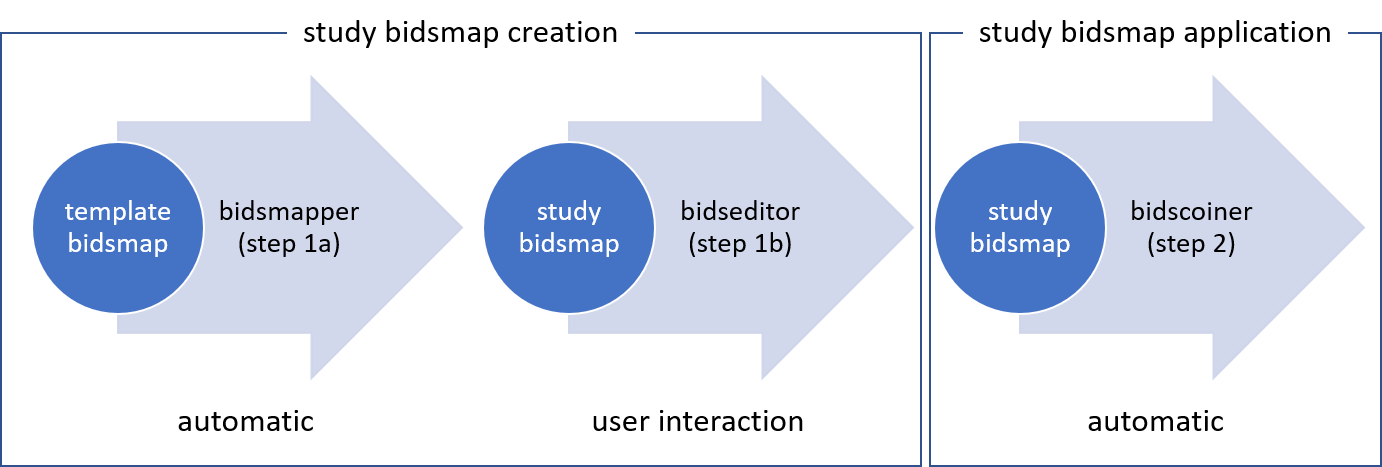

In [5]:
await lmod.load('bidscoin/4.3.3')

In [16]:
%%bash
mkdir bidscoin_bidsmap
bidsmapper ./heudiconv-reproin-example/REPROIN/dicom ./bidscoin_bidsmap --subprefix '00' --sesprefix 'Patterson_Coben'   # Scans your data and creates a study bidsmap
bidscoiner ./heudiconv-reproin-example/REPROIN/dicom ./bidscoin_bids    # Converts your data to BIDS using the study bidsmap

INFO | 
INFO | -------------- START BIDSmapper ------------
INFO | >>> bidsmapper sourcefolder=/data/books/workflows/heudiconv-reproin-example/REPROIN/dicom bidsfolder=/data/books/workflows/bidscoin_bidsmap bidsmap=bidsmap.yaml template=/home/jovyan/.bidscoin/4.3.3+qt5/templates/bidsmap_dccn.yaml plugins=[] subprefix=00 sesprefix=Patterson_Coben store=False force=False
INFO | No existing bidsmap file found: /data/books/workflows/bidscoin_bidsmap/code/bidscoin/bidsmap.yaml
INFO | Reading: /home/jovyan/.bidscoin/4.3.3+qt5/templates/bidsmap_dccn.yaml
INFO | Checking the bidsmap run-items:
SUCCESS | All datatypes and options in the template bidsmap are valid
INFO | Mapping: /data/books/workflows/heudiconv-reproin-example/REPROIN/dicom/001/Patterson_Coben - 1 (subject 1/10)
VERBOSE | Executing plugin: dcm2niix2bids -> /data/books/workflows/heudiconv-reproin-example/REPROIN/dicom/001/Patterson_Coben - 1
INFO | Mapping: /data/books/workflows/heudiconv-reproin-example/REPROIN/dicom/001-anat-sc

## Process data

### Brain extraction using FSL BET

In [7]:
await lmod.load('fsl/6.0.7.4')
await lmod.list()

['dcm2niix/v1.0.20240202', 'fsl/6.0.7.4']

In [ ]:
%%bash
mkdir -p segmentation
declare -a niifile=($(find ./heudiconv_bids/Patterson/Coben/sub-001/anat/ -type f -iname "*.nii.gz"));

for filepath in "${niifile[@]}"; do
    # Extract the base filename without the path
    filename=$(basename "$filepath")

    # Extract the name without the extension
    name="${filename%.*}"

    # Output the current file
    echo "Processing file: $filepath"

    # Run BET and save the result
    output="./segmentation/${name%.*}_brain"
    echo "Saving output to: $output"
    bet "$filepath" "$output"
done

Processing file: ./heudiconv_bids/Patterson/Coben/sub-001/anat/sub-001_acq-MPRAGE_T1w.nii.gz
Saving output to: ./segmentation/sub-001_acq-MPRAGE_T1w_brain


### Visualize the brain segmentation

In [14]:
from ipyniivue import AnyNiivue
nv = AnyNiivue()
nv.load_volumes([{"path": "/data/books/workflows/bidscoin_bids/sub-1/ses-1/anat/sub-1_ses-1_acq-anatT1wacqMPRAGE_T1w.nii.gz"}])
nv

AnyNiivue()

## Share your data to OSF

To set the username, project ID and token by using a configuration file, create `.osfcli.config` in the current directory:
```markdown
[osf]
username = yourOSFaccount@example.com
project = 9zpcy
token = kej2R9IU6Gr2uThsswSNdP1cd0cu9eaCerVXjVf7zNwfXHyT0QzMZtX0PGTYmp9Fzaixwq
```

To upload file to the project set in configuration file, run `osf upload source destination`.

In [25]:
!osf upload -r ./segmentation segmentation